<a href="https://colab.research.google.com/github/Dirkster99/PyNotes/blob/master/Transformers/Issue/66_Transformer_4_Language_Classification_MultiLabel_DistilBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers==4.2.1

# Six steps towards building a Language Classification Model with Transformers and TensorFlow 2.0

Original Author: James Briggs
https://www.youtube.com/watch?v=GYDFBfx8Ts8

## Download and Preprocessing Data

### 20 News Groups Categorization Dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
dataPath = '/gdrive/MyDrive/Colab Notebooks/MultiLabelText/ToxicComments/jigsaw_toxicity_pred/'
!ls {dataPath.replace(' ', '\ ')}  -lha

total 246M
-rw------- 1 root root 58M Mar  5 09:36 test.csv
-rw------- 1 root root 58M Mar  5 10:49 test_labels.csv
-rw------- 1 root root 66M Mar  5 09:36 train_conv.csv
-rw------- 1 root root 66M Mar  5 09:36 train.csv
-rw------- 1 root root   0 Mar  5 11:13 train.csv.lock


In [ ]:
import pandas as pd
df = pd.read_csv(dataPath + 'train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.count()

id               159571
comment_text     159571
toxic            159571
severe_toxic     159571
obscene          159571
threat           159571
insult           159571
identity_hate    159571
dtype: int64

In [ ]:
# drop rows without a single flag in it
indexNames = df[ (df['toxic'] == 0)
               & (df['severe_toxic'] == 0)
               & (df['obscene'] == 0)
               & (df['threat'] == 0)
               & (df['insult'] == 0)
               & (df['identity_hate'] == 0)
                ].index
df.drop(indexNames , inplace=True)

In [ ]:
df.count()

id               16225
comment_text     16225
toxic            16225
severe_toxic     16225
obscene          16225
threat           16225
insult           16225
identity_hate    16225
dtype: int64

### Build Label Dictionaries

In [ ]:
labelHeadings = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
labelHeadings

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
label2index = {}
index2label = {}
for i in range(len(labelHeadings)):
  label2index[labelHeadings[i]] = i
  index2label[i] = labelHeadings[i]

#print (f"labelHeadings: {labelHeadings}")
#print (f" label2index: {label2index}")
#print (f" index2label: {index2label}")

for i in range(len(labelHeadings)):
  print (f"{i} -> {label2index[labelHeadings[i]]}, labelHeaders: {labelHeadings[i]} -> {index2label[i]}")

0 -> 0, labelHeaders: toxic -> toxic
1 -> 1, labelHeaders: severe_toxic -> severe_toxic
2 -> 2, labelHeaders: obscene -> obscene
3 -> 3, labelHeaders: threat -> threat
4 -> 4, labelHeaders: insult -> insult
5 -> 5, labelHeaders: identity_hate -> identity_hate


### Multi-Hot Encode Labels and Reformate for text and lables columns

In [ ]:
df.drop(['id'], inplace=True, axis=1)

In [ ]:
df.rename(columns = {'comment_text' : 'text'}, inplace=True)

In [ ]:
# Hot Encode 6 Label columns (starting at 2nd column 'till and of DataFrame)
# into 1 column with a hot encoded list of values
df['labels'] = df.iloc[:, 1:].values.tolist()

In [ ]:
for label in labelHeadings:
  df.drop(axis=1, columns=label, inplace=True)

In [ ]:
df.head()

,text,labels
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,"[1, 1, 1, 0, 1, 0]"
12,Hey... what is it..\n@ | talk .\nWhat is it......,"[1, 0, 0, 0, 0, 0]"
16,"Bye! \n\nDon't look, come or think of comming ...","[1, 0, 0, 0, 0, 0]"
42,You are gay or antisemmitian? \n\nArchangel WH...,"[1, 0, 1, 0, 1, 1]"
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!","[1, 0, 1, 0, 1, 0]"


In [ ]:
df.count()

text      16225
labels    16225
dtype: int64

### Multi Hot Encode a continues label value (eg. 0-4) as array

In [ ]:
arr = df['labels'].values
print ( f"arr.size: {arr.size}")
print ( f" arr.max: {arr.max()}")
print ( f" arr.max: {len(arr.max())}")

arr.size: 16225
 arr.max: [1, 1, 1, 1, 1, 1]
 arr.max: 6


In [ ]:
import numpy as np
labels = np.zeros((arr.size, len(arr.max())), dtype=float)
print (f"labels shape: {labels.shape}")
print (f"labels:\n{labels}")

labels shape: (16225, 6)
labels:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [ ]:
for i in range(len(labels)):
  labels[i] = np.array(arr[i])

In [ ]:
labels

array([[1., 1., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 1., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0.]])

In [ ]:
print (f"array size: {labels.size},\narray: {labels}")

array size: 97350,
array: [[1. 1. 1. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [1. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 1. 0.]]


In [ ]:
for i in range(0, 20):
  print(labels[i])

[1. 1. 1. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]
[1. 0. 1. 0. 1. 1.]
[1. 0. 1. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[1. 0. 1. 0. 0. 0.]
[1. 1. 1. 0. 1. 0.]
[1. 0. 1. 0. 1. 0.]
[1. 0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]
[1. 0. 1. 0. 1. 0.]
[1. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 1. 0.]
[1. 0. 1. 0. 1. 1.]
[1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 1. 0.]
[1. 0. 1. 1. 1. 1.]
[0. 0. 0. 0. 1. 0.]


### Encode Text Input Data

In [ ]:
seqlen = df['text'].apply(lambda x: len(x.split()))

In [ ]:
import seaborn as sns
import matplotlib as plt

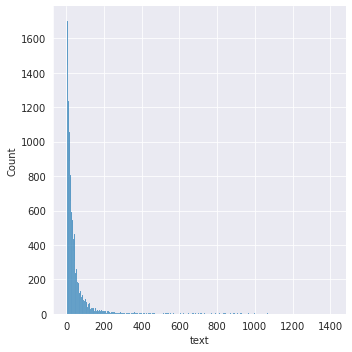

In [ ]:
# Do a distribution plot on the seqquence length's of the given text
sns.set_style('darkgrid')
plt.figure.Figure(figsize=(16,10))
sns.displot(seqlen)

In [ ]:
# Maximum length of the text we are going to train and predict here
SEQ_LEN = 100

## Encode Input Data
Encode the Input-Tensor and the Attention Tensor.

In [ ]:
modelPath = '/gdrive/MyDrive/Colab Notebooks/Transformers/LocalModelUsage/distilbert-base-multilingual-cased/'
!ls {modelPath.replace(' ', '\ ')} -lha

total 1.3G
-rw------- 1 root root 1.3G Mar  8 18:56  distilbert-base-multilingual-cased.zip
-rw------- 1 root root 9.8K Mar  8 18:57 'Model Download Save.ipynb'
-rw------- 1 root root 102K Mar  8 19:17 'Model Load.ipynb'


In [ ]:
!unzip {(modelPath+'distilbert-base-multilingual-cased.zip').replace(' ', '\ ')} -d localModel

Archive:  /gdrive/MyDrive/Colab Notebooks/Transformers/LocalModelUsage/distilbert-base-multilingual-cased/distilbert-base-multilingual-cased.zip
replace localModel/distilbert-base-multilingual-cased/config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: localModel/distilbert-base-multilingual-cased/config.json  
  inflating: localModel/distilbert-base-multilingual-cased/pytorch_model.bin  A

  inflating: localModel/distilbert-base-multilingual-cased/README.md  
  inflating: localModel/distilbert-base-multilingual-cased/tf_model.h5  
 extracting: localModel/distilbert-base-multilingual-cased/tokenizer_config.json  
  inflating: localModel/distilbert-base-multilingual-cased/tokenizer.json  
  inflating: localModel/distilbert-base-multilingual-cased/vocab.txt  


In [ ]:
from transformers import DistilBertTokenizer
tranformersPreTrainedModelName = 'localModel/distilbert-base-multilingual-cased/'
tokenizer = DistilBertTokenizer.from_pretrained(tranformersPreTrainedModelName) 

In [ ]:
tokens = tokenizer.encode_plus('Hello World'
                               ,max_length = SEQ_LEN          # Using text with this max length
                               ,truncation=True               # truncate any text longer than max_length
                               ,padding='max_length'          # padd text that is smaller than max_length
                               ,add_special_tokens=True       # add special tokens for start, end of sentence, unknown, and mask tokens
                               ,return_token_type_ids = False # do not return ids for types of tokens
                               ,return_attention_mask = True
                               ,return_tensors='tf')

In [ ]:
# Outputs 2 tensors named 'input_ids' & 'attention_mask'
# The values 101 and 102 are start and end of sentence identifiers
# while 7592 & 2088 are tokens for 'Hello World'
#
# Attention Mask tells Bert which tokens to pay attention to and which to ompletely ignore
print (tokens)

{'input_ids': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[  101, 31178, 10315,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 100), dtype=int32, numpy=
array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

### Tokenize each Sample in Dataset

In [ ]:
import numpy as np
# initialize numpy arrays for Token-Ids and Attention Masks
Xids = np.zeros((len(df), SEQ_LEN), dtype=float)
Xmask = np.zeros((len(df), SEQ_LEN), dtype=float)

In [ ]:
Xids.shape

(16225, 100)

In [ ]:
# Use a simple for loop to encode all data points
for i, sequence in enumerate(df['text']):
  tokens = tokenizer.encode_plus(sequence
                               ,max_length = SEQ_LEN          # Using text with this max length
                               ,truncation=True               # truncate any text longer than max_length
                               ,padding='max_length'          # padd text that is smaller than max_length
                               ,add_special_tokens=True       # add special tokens for start, end of sentence, unknown, and mask tokens
                               ,return_token_type_ids = False # do not return ids for types of tokens
                               ,return_attention_mask = True
                               ,return_tensors='tf')
  
  Xids[i, :], Xmask[i, :] = tokens['input_ids'], tokens['attention_mask']

In [ ]:
# Array of tokenized Ids
Xids

array([[  101., 32992., 10858., ...,     0.,     0.,     0.],
       [  101., 35936.,   119., ...,   119.,   119.,   102.],
       [  101., 58776.,   106., ...,     0.,     0.,     0.],
       ...,
       [  101., 13554., 11357., ...,     0.,     0.,     0.],
       [  101.,   107., 35936., ..., 10105., 60083.,   102.],
       [  101., 10111.,   177., ...,     0.,     0.,     0.]])

In [ ]:
# Array of attaention masks
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [ ]:
print (type(Xids))
print (type(Xmask))
print (type(labels))
print (type(labels[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Save Tokenized Data

In [ ]:
with open ('xids.npy', 'wb') as f:
  np.save(f, Xids)
with open ('xmask.npy', 'wb') as f:
  np.save(f, Xmask)
with open ('labels.npy', 'wb') as f:
  np.save(f, labels)

del df, Xids, Xmask, labels
df = None

## Ininitializing Hugging Face Tokenizer and Model

### Load Tokenized Data

In [ ]:
import numpy as np
with open ('xids.npy', 'rb') as f:
  Xids = np.load(f)
with open ('xmask.npy', 'rb') as f:
  Xmask = np.load(f)
with open ('labels.npy', 'rb') as f:
  labels = np.load(f)

In [ ]:
Xids

array([[  101., 32992., 10858., ...,     0.,     0.,     0.],
       [  101., 35936.,   119., ...,   119.,   119.,   102.],
       [  101., 58776.,   106., ...,     0.,     0.,     0.],
       ...,
       [  101., 13554., 11357., ...,     0.,     0.,     0.],
       [  101.,   107., 35936., ..., 10105., 60083.,   102.],
       [  101., 10111.,   177., ...,     0.,     0.,     0.]])

In [ ]:
for i in range(0, 20):
  print(labels[i])

[1. 1. 1. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]
[1. 0. 1. 0. 1. 1.]
[1. 0. 1. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[1. 0. 1. 0. 0. 0.]
[1. 1. 1. 0. 1. 0.]
[1. 0. 1. 0. 1. 0.]
[1. 0. 1. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]
[1. 0. 1. 0. 1. 0.]
[1. 0. 0. 1. 0. 0.]
[1. 0. 0. 0. 1. 0.]
[1. 0. 1. 0. 1. 1.]
[1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 1. 0.]
[1. 0. 1. 1. 1. 1.]
[0. 0. 0. 0. 1. 0.]


In [ ]:
import tensorflow as tf
#tf.config.list_physical_device('GPU')

In [ ]:
# TensorFlow expects input and target labels as an input tuple
# Bert expects a dictionary of 'input_ids' and 'attention_mask' as input
# So, lets create the dataset object
# This creates a generator for a tuple of input tokens, attention_masks, and target labels
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [ ]:
# View a single row in the dataset
print (dataset.take(1))
print ()
for i in dataset.take(1):
  print (i)

<TakeDataset shapes: ((100,), (100,), (6,)), types: (tf.float64, tf.float64, tf.float64)>

(<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([   101.,  32992.,  10858.,  62828.,  93089.,  11733.,  24093.,
        46291.,  11565.,  42622.,  11259., 100061.,    153.,  19088.,
        10731.,  50884.,  11403.,  69849.,  11490.,  49339.,  94592.,
          160.,  42622.,  11733.,    102.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,     

In [ ]:
# minute 21:55
# TensorFlow Bert model expects our input in a Tuple format containing:
# 1) 'input_ids' and 'attention_mask' in a Dictionary and
# 2) a label as 2nd part of the tupel
def map_func(input_ids, masks, labels):
  return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [ ]:
# we can use the dataset map function to apply this format
dataset = dataset.map(map_func)

In [ ]:
# View a single row in the dataset
print (dataset.take(1))
print ()
for i in dataset.take(1):
  print (i)

<TakeDataset shapes: ({input_ids: (100,), attention_mask: (100,)}, (6,)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

({'input_ids': <tf.Tensor: shape=(100,), dtype=float64, numpy=
array([   101.,  32992.,  10858.,  62828.,  93089.,  11733.,  24093.,
        46291.,  11565.,  42622.,  11259., 100061.,    153.,  19088.,
        10731.,  50884.,  11403.,  69849.,  11490.,  49339.,  94592.,
          160.,  42622.,  11733.,    102.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,   

In [ ]:
# SHuffle and Bach Dataset
#dataset = dataset.shuffle(1000).batch(32)

In [ ]:
# Get the total size of dataset now that it is batched
#
# the dataset object is a generator object so we cannot take the length of it directly
# thus, we have to convert it into a list
# 
# Do not do this with a very large dataset
#
DS_LEN = len(list(dataset))
DS_LEN

16225

In [ ]:
print (f"Alternative Computation for DS_LEN: {len(Xids)/32} -> {round(len(Xids)/32, 0)}")

Alternative Computation for DS_LEN: 507.03125 -> 507.0


In [ ]:
SPLIT = .8

# take or skip the specified number of batches to split by factor
test = dataset.skip(round(DS_LEN * SPLIT)).batch(32)
trainevalu = dataset.take(round(DS_LEN * SPLIT))

DS_LEN2 = len(list(trainevalu))

train = trainevalu.take(round(DS_LEN2 * SPLIT)).shuffle(1000).batch(32)
evalu = trainevalu.skip(round(DS_LEN2 * SPLIT)).shuffle(1000).batch(32)

del dataset

In [ ]:
print (f"test data: {len(test)}")
print (f"train data: {len(train)}, train evalu data: {len(evalu)}")

test data: 102
train data: 325, train evalu data: 82


## Build Model

In [ ]:
from transformers import DistilBertConfig
bertConfig = DistilBertConfig.from_pretrained(tranformersPreTrainedModelName
                                        , output_hidden_states=True
                                        , num_lables=6
                                        , max_length=SEQ_LEN
                                        , label2id=label2index
                                        , id2label=index2label
                                        )

In [ ]:
from transformers import TFDistilBertForSequenceClassification
bert = TFDistilBertForSequenceClassification.from_pretrained(tranformersPreTrainedModelName, config=bertConfig)

Some layers from the model checkpoint at localModel/distilbert-base-multilingual-cased/ were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at localModel/distilbert-base-multilingual-cased/ and are newly initialized: ['dropout_104', 'pre_classifier', 'classifier']
You should probably TRAIN this 

In [ ]:
bert.summary()

Model: "tf_distil_bert_for_sequence_classification_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  134734080 
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  4614      
_________________________________________________________________
dropout_104 (Dropout)        multiple                  0         
Total params: 135,329,286
Trainable params: 135,329,286
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# build 2 input layers to Bert Model where name needs to match the input values in the dataset
input_ids = tf.keras.Input(shape=(SEQ_LEN,), name = 'input_ids', dtype='int32')
mask = tf.keras.Input(shape=(SEQ_LEN,), name = 'attention_mask', dtype='int32')

embedings = bert.layers[0](input_ids, attention_mask=mask)[0]

#Original Author: Ferry Djaja
#https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592
X = tf.keras.layers.Dropout(0.5)(embedings)
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256))(X)
y = tf.keras.layers.Dense(len(label2index), activation='sigmoid', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids,mask], outputs=y)

# Freeze the Bert model by freezing this layer to make training less of an overkill in terms of required performance
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
distilbert (TFDistilBertMainLay TFBaseModelOutput(la 134734080   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_105 (Dropout)           (None, 100, 768)     0           distilbert[0][7]           

In [ ]:
#
# https://stackoverflow.com/questions/52125924/why-does-sigmoid-crossentropy-of-keras-tensorflow-have-low-precision
# keras with custom loss function
def customLoss(target, output):
    # if not from_logits:
    #     # transform back to logits
    #     _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
    #     output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    #     output = tf.log(output / (1 - output))
    output = tf.math.log(output / (1 - output))
    return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
    loss=customLoss,
    optimizer=optimizer,
    metrics=['accuracy']
    )

#loss=tf.keras.losses.BinaryCrossentropy()
#optimizer = tf.keras.optimizers.Adam()  #lr=1e-3,  lr=0.001, decay=1e-6
#model.compile(
#    loss=loss,
#    optimizer=optimizer,
#    metrics=['accuracy']
#    )

In [ ]:
from timeit import default_timer as timer
from datetime import timedelta
import os

start = timer()

checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    cp_callback
]

history = model.fit(train
                    , validation_data=evalu
                    , callbacks=callbacks, verbose=1
                    , epochs=32)

end = timer()
print(timedelta(seconds=end-start))

Epoch 1/32
325/325 [==============================] - 63s 171ms/step - loss: 0.3678 - accuracy: 0.9280 - val_loss: 0.3136 - val_accuracy: 0.9357

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/32
325/325 [==============================] - 52s 160ms/step - loss: 0.3116 - accuracy: 0.9422 - val_loss: 0.3069 - val_accuracy: 0.9307

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/32
325/325 [==============================] - 52s 161ms/step - loss: 0.2952 - accuracy: 0.9423 - val_loss: 0.3030 - val_accuracy: 0.8775

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/32
325/325 [==============================] - 52s 161ms/step - loss: 0.2831 - accuracy: 0.9259 - val_loss: 0.2922 - val_accuracy: 0.9314

Epoch 00004: saving model to training_1/cp.ckpt
Epoch 5/32
325/325 [==============================] - 52s 161ms/step - loss: 0.2754 - accuracy: 0.9299 - val_loss: 0.2986 - val_accuracy: 0.8921

Epoch 00005: saving model to training_1/cp.ckpt
Epoch 6/32
325/325 [==========

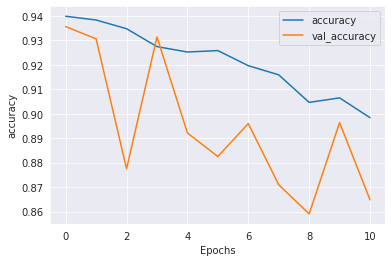

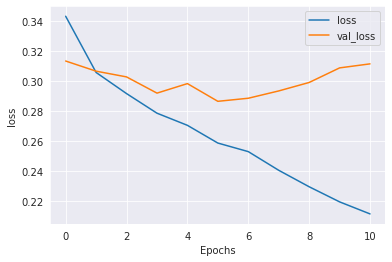

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Evaluation

In [ ]:
results = model.evaluate(test, batch_size=32)
print("test loss, test acc:", results)

102/102 [==============================] - 12s 114ms/step - loss: 0.3142 - accuracy: 0.8690
test loss, test acc: [0.3142384886741638, 0.8690292835235596]


In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 1 sample")
predictions = model.predict(test.take(1))
print("predictions shape:", predictions.shape)

Generate predictions for 1 sample
predictions shape: (32, 6)


In [ ]:
threshold = .6

for item in test.take(1):
  #print (f"inputs: {item [0]}")
  print ()
  #print (f"labels: {item [1]}")
  countOK = 0
  countNOK = 0

  for i in range(len(predictions)):

    labelValues = item[1][i].numpy()
    for l in range(len(labelValues)):
      #print (f"labelValues: {labelValues[l]} predictions: {predictions[1][l]}")
      if (labelValues[l] == 1. and predictions[1][l] > threshold):
        print (f"1  OK Actual label: {index2label[l]} predicted with score: {format(predictions[1][l], '.6f')}")
        countOK = countOK + 1
      elif (labelValues[l] == 1. and predictions[1][l] <= threshold):
        print (f"2 NOK Actual label: {index2label[l]} predicted with score: {format(predictions[1][l], '.6f')}")
        countNOK = countNOK + 1
      elif (labelValues[l] == 0. and predictions[1][l] > threshold):
        print (f"3 NOK Actual label: {index2label[l]} predicted with score: {format(predictions[1][l], '.6f')}")
        countNOK = countNOK + 1
      elif (labelValues[l] == 0. and predictions[1][l] <= threshold):
        #print (f"4  OK Actual label: {index2label[l]} NOT predicted with score: {format(predictions[1][l], '.6f')}")
        countOK = countOK + 1

    print ()

  sumCount = countNOK+countOK
  print (f"OK + NOK: {format(sumCount, '3d')}")
  if sumCount > 0:
    print (f"      OK: {format(countOK, '3d')} ->  True: {format(((countOK/sumCount)*100), '.3f')}%")
    print (f"     NOK: {format(countNOK, '3d')} -> False: {format(((countNOK/sumCount)*100), '.3f')}%")



1  OK Actual label: toxic predicted with score: 0.981155
1  OK Actual label: obscene predicted with score: 0.986903
1  OK Actual label: insult predicted with score: 0.629928

1  OK Actual label: toxic predicted with score: 0.981155
1  OK Actual label: obscene predicted with score: 0.986903
1  OK Actual label: insult predicted with score: 0.629928

1  OK Actual label: toxic predicted with score: 0.981155
3 NOK Actual label: obscene predicted with score: 0.986903
3 NOK Actual label: insult predicted with score: 0.629928

3 NOK Actual label: toxic predicted with score: 0.981155
3 NOK Actual label: obscene predicted with score: 0.986903
1  OK Actual label: insult predicted with score: 0.629928

1  OK Actual label: toxic predicted with score: 0.981155
1  OK Actual label: obscene predicted with score: 0.986903
3 NOK Actual label: insult predicted with score: 0.629928

1  OK Actual label: toxic predicted with score: 0.981155
3 NOK Actual label: obscene predicted with score: 0.986903
1  OK Ac

In [ ]:
!ls training_1/ -lh

total 539M
-rw-r--r-- 1 root root   71 Mar 16 23:54 checkpoint
-rw-r--r-- 1 root root 539M Mar 16 23:54 cp.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root 8.9K Mar 16 23:54 cp.ckpt.index
